In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import time

import numpy
import os
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
params = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*params)])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 48.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
def show_images(images, title):
    W_COUNT, H_COUNT = 8, 8
    F_SIZE = (8, 8)
    fig, axes = plt.subplots(H_COUNT, W_COUNT, figsize = F_SIZE)
    fig.suptitle(title)
    plt.setp(plt.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img = images[i][0] * torch.tensor(params[1]).reshape(3, 1, 1) + torch.tensor(params[0]).reshape(3, 1, 1)
        img = img.numpy().transpose(1, 2, 0)
        ax.imshow((255 * img).astype('uint8'))

Number of train samples: 50000
Number of test samples: 10000


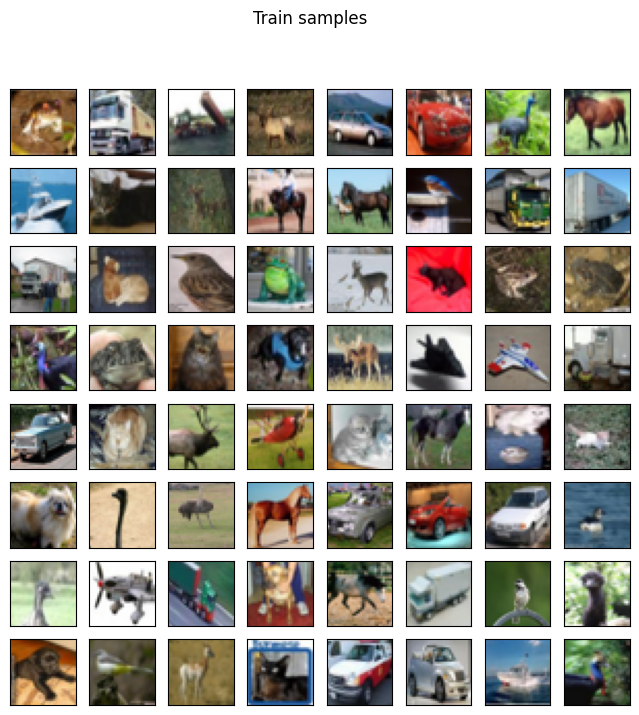

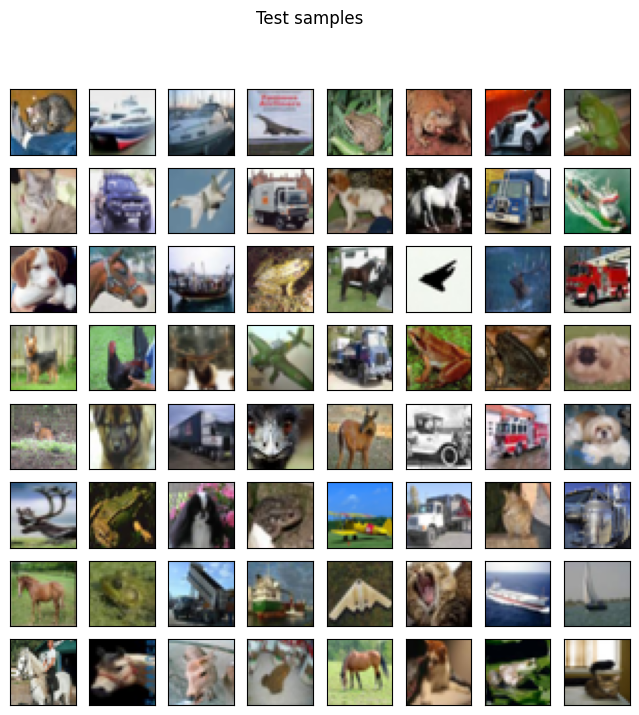

In [4]:
print('Number of train samples: {}'.format(len(trainset)))
show_images(trainset, 'Train samples')
print('Number of test samples: {}'.format(len(testset)))
show_images(testset, 'Test samples')

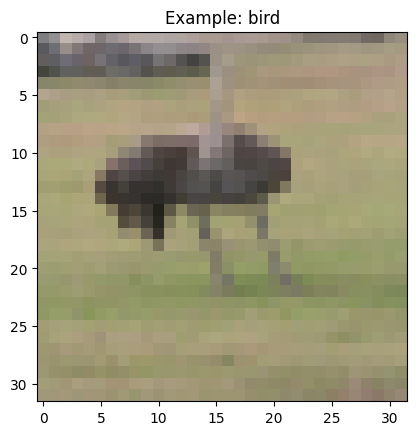

In [5]:
classes = trainset.classes
img = trainset[42][0] * torch.tensor(params[1]).reshape(3, 1, 1) + torch.tensor(params[0]).reshape(3, 1, 1)
img = img.numpy().transpose(1, 2, 0)
plt.title(f"Example: {classes[trainset[42][1]]}")
plt.imshow((img * 255).astype('uint8'))

In [6]:
class Net(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [7]:
net = Net()
net

Net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
device

device(type='cuda')

In [10]:
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [11]:
def accuracy(outputs, labels):
  _, predicted = torch.max(outputs.data, 1)
  return torch.sum(predicted == labels).item() / len(predicted)

Epoch #1: loss = 1.7115959972262382, acc = 0.3797, time = 84.73714137077332


Test: loss = 1.1832560800492764, acc = 0.5676


Epoch #2: loss = 1.2428025039117876, acc = 0.5704, time = 85.52154064178467


Test: loss = 0.9614827251031296, acc = 0.6696


100%|██████████| 12500/12500 [01:24<00:00, 147.65it/s]

Epoch #3: loss = 0.9892523631408345, acc = 0.66368, time = 84.71073150634766


Test: loss = 0.7833639019077644, acc = 0.7345


Epoch #4: loss = 0.814038761588668, acc = 0.72304, time = 86.06799578666687


Test: loss = 0.67960980322174, acc = 0.7718


Epoch #5: loss = 0.6772751524744351, acc = 0.7701, time = 85.42706418037415


Test: loss = 0.6294002943549902, acc = 0.7918


Epoch #6: loss = 0.5655192033928732, acc = 0.80826, time = 84.52011942863464


Test: loss = 0.547865104327786, acc = 0.8199


Epoch #7: loss = 0.48109212878380975, acc = 0.83816, time = 84.97928833961487


Test: loss = 0.5364793924100901, acc = 0.821


Epoch #8: loss = 0.40801095736101395, acc = 0.86226, time = 85.23375034332275


Test: loss = 0.5234193768338635, acc = 0.828


Epoch #9: loss = 0.3463095520762464, acc = 0.88392, time = 86.03299117088318


Test: loss = 0.5393837388015822, acc = 0.8355


Epoch #10: loss = 0.2925221804251416, acc = 0.89984, time = 85.27516961097717


Test: loss = 0.5451751061799158, acc = 0.8363


Epoch #11: loss = 0.24990232955002448, acc = 0.91568, time = 85.89901328086853


Test: loss = 0.4869017404328464, acc = 0.8532


Epoch #12: loss = 0.20572324106786097, acc = 0.9294, time = 85.04661417007446


Test: loss = 0.4842153321037089, acc = 0.8556


Epoch #13: loss = 0.16720189835732707, acc = 0.94278, time = 85.55069994926453


Test: loss = 0.5134026998855439, acc = 0.8501


Epoch #14: loss = 0.1398624281082346, acc = 0.95222, time = 85.27066540718079
Test: loss = 0.5574535893895557, acc = 0.8488


Epoch #15: loss = 0.12143125423451936, acc = 0.95902, time = 85.33733367919922


Test: loss = 0.5700612029203345, acc = 0.8482


Epoch #16: loss = 0.10138920047027437, acc = 0.96542, time = 84.84196376800537


Test: loss = 0.6999107849128747, acc = 0.8363


Epoch #17: loss = 0.09219812840695595, acc = 0.9688, time = 85.6866090297699


Test: loss = 0.6080899613707311, acc = 0.8587


Epoch #18: loss = 0.08236919942233926, acc = 0.97212, time = 84.64797949790955


Test: loss = 0.5973404056357217, acc = 0.8572


Epoch #19: loss = 0.06928708354787497, acc = 0.97706, time = 85.32382845878601


Test: loss = 0.6110439820085627, acc = 0.8503


Epoch #20: loss = 0.05941515173514259, acc = 0.98064, time = 83.96535086631775


Test: loss = 0.7010512274096704, acc = 0.8433
Total time 1897.4110651016235


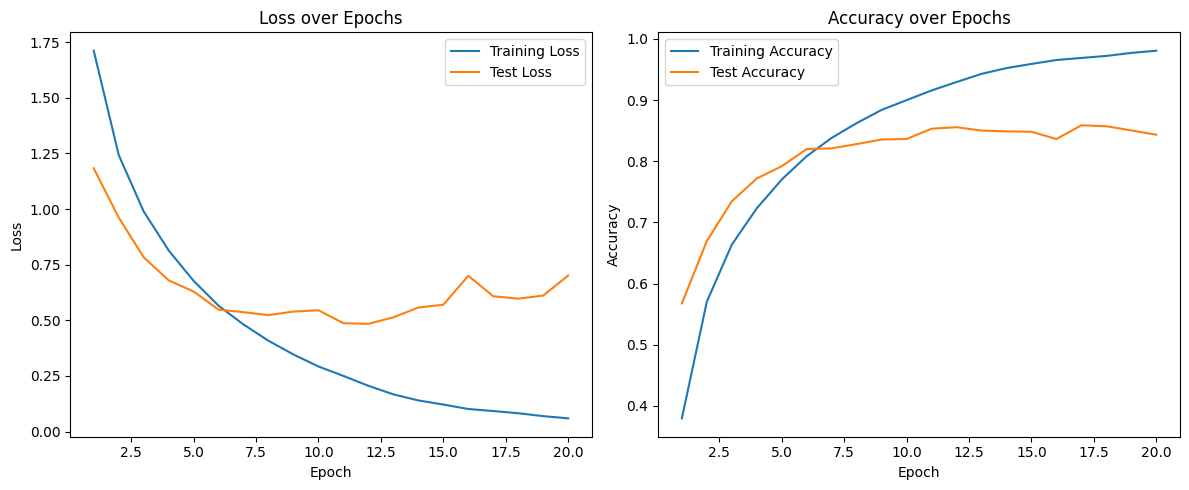

In [12]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

EPOCHS = 20
start = time.time()

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    start_epoch = time.time()
    accs = 0
    total_loss = 0

    net.train()
    for i, (images, labels) in tqdm(enumerate(trainloader), total=len(trainloader), leave=bool(epoch == 2)):
        labels, images = labels.to(device), images.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        acc = accuracy(outputs, labels)
        total_loss += loss.item()
        accs += acc
        loss.backward()
        optimizer.step()

    train_losses.append(total_loss / len(trainloader))
    train_accuracies.append(accs / len(trainloader))

    end_epoch = time.time()
    print(f'Epoch #{epoch + 1}: loss = {train_losses[-1]}, acc = {train_accuracies[-1]}, time = {end_epoch - start_epoch}')

    net.eval()
    test_loss = 0
    test_accs = 0
    with torch.no_grad():
        for images, labels in testloader:
            labels, images = labels.to(device), images.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)
            test_loss += loss.item()
            test_accs += acc

    test_losses.append(test_loss / len(testloader))
    test_accuracies.append(test_accs / len(testloader))

end = time.time()
print('Total time {}'.format(end - start))

# Plotting the learning curve
plt.figure(figsize=(12, 5))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, EPOCHS + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
true_predicted = 0
n = 0
loss = 0
with torch.no_grad():
        for images, labels in testloader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = net(images)
            loss += criterion(outputs, labels)
            n += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            true_predicted += (predicted == labels).sum()
print(f'Loss = {loss / n:.4f}, Test accuracy = {true_predicted / n:.4f}')

Loss = 0.1753, Test accuracy = 0.8433


In [15]:
test_loss = 0
test_accs = 0
n = 0

with torch.no_grad():
    for images, labels in testloader:
        labels = labels.to(device)
        images = images.to(device)

        outputs = net(images)
        loss = criterion(outputs, labels)
        acc = accuracy(outputs, labels)

        test_loss += loss.item() * images.size(0)
        test_accs += acc * images.size(0)
        n += labels.size(0)

test_loss /= n
test_accuracy = test_accs / n

print(f'Test: loss = {test_loss:.4f}, acc = {test_accuracy:.4f}')

Test: loss = 0.7011, acc = 0.8433
